# Plotting Shapefiles - Montreal Dataset

A little script to load, manage and plot shapefiles

The dataset in question can be found at the following address: http://donnees.ville.montreal.qc.ca/dataset/geobase


In [1]:
### Import Dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns

import shapefile as shp
from pyproj import Proj, transform

%matplotlib inline

The data we need is in the ".shp" file, so we load that using the shapefile package

In [2]:
filename = "./data/geobase_mtl.shp"
sf = shp.Reader(filename)

We can convert this file to a pandas dataframe for easier navigation. Larger shapefiles may be slower to do this conversion and it may proven faster/more efficient to extract fields of interest before converting to a dataframe

In [3]:
fields = [x[0] for x in sf.fields][1:] # Extract the field titles from the shapefile
records = sf.records() # A list of "record" data type
shps = [s.points for s in sf.shapes()] # Make a list of lists for the coordinates of each item in the file

df = pd.DataFrame(columns=fields, data=records) # Create the dataframe from the records
df = df.assign(coords=shps) # Append the xy coordinates to the dataframe

df.head()

,ID_TRC,DEB_GCH,FIN_GCH,ARR_GCH,SENS_CIR,CLASSE,LIE_VOIE,TYP_VOIE,DIR_VOIE,NOM_VOIE,DEB_DRT,FIN_DRT,ARR_DRT,LIM_GCH,LIM_DRT,coords
0,1010001,12320,12340,Ahuntsic-Cartierville,0,0,,avenue,,Adhémar-Mailhiot,12323,12335,Ahuntsic-Cartierville,Montréal,Montréal,"[(285986.423, 5042145.34), (285897.824, 504222..."
1,1010004,5530,5570,Ahuntsic-Cartierville,0,0,,place,,D'Aiguillon,5475,5625,Ahuntsic-Cartierville,Montréal,Montréal,"[(288690.550115, 5043101.721475), (288685.9272..."
2,1010005,7750,7830,Ahuntsic-Cartierville,0,0,,avenue,,Albert-LeSage,7745,7805,Ahuntsic-Cartierville,Montréal,Montréal,"[(286274.69237, 5042754.459125), (286269.73885..."
3,1010006,12200,12238,Ahuntsic-Cartierville,0,0,,avenue,,Albert-Prévost,0,0,Ahuntsic-Cartierville,Montréal,Montréal,"[(286373.69, 5042390.673), (286368.68571, 5042..."
4,1010007,12240,12270,Ahuntsic-Cartierville,0,0,,avenue,,Albert-Prévost,0,0,Ahuntsic-Cartierville,Montréal,Montréal,"[(286316.148, 5042442.785), (286310.873235, 50..."


This shapefile, while smaller than others I had discovered, still contained many records

In [4]:
len(df)

47391

I was concerned that a plot with ~50,000 lines may be too busy, and slow to plot. So next I filter the data by "Classe", to leave only highways, main roads and residential roads (see documentation). These accounted for classes 0,6,7,8,9

In [5]:
dfF = df[(df["CLASSE"].between(6,9)) | (df["CLASSE"] == 0)]
len(dfF)

39568

Ok, so this didn't really reduce the number of lines to plot, but oh well.

To try and plot this data, I initially decided to try and apply a lambda function to extract x and y coordinates and plot. This worked, but was SUPER SLOW. Below I just plot the first 1000 linesand this already takes a couple of seconds on my laptop. If you're feeling patient, remove the "[:1000]" index.

0        [Line2D(_line0)]
1        [Line2D(_line1)]
2        [Line2D(_line2)]
3        [Line2D(_line3)]
4        [Line2D(_line4)]
              ...        
995    [Line2D(_line995)]
996    [Line2D(_line996)]
997    [Line2D(_line997)]
998    [Line2D(_line998)]
999    [Line2D(_line999)]
Name: coords, Length: 1000, dtype: object

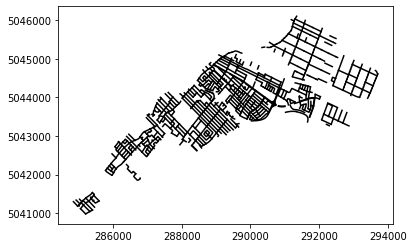

In [6]:
fig,ax = plt.subplots()
plotFunc = lambda d: ax.plot([coord[0] for coord in d],[coord[1] for coord in d],"black")
df["coords"][:1000].apply(plotFunc)

I prayed that there was a better way. Low and behold, **Line Collections** were the answer. 

To initialise a collection of lines, we can pass in a list of lists of tuples - conveniently the data in the shapefile is already arrange in (x,y) tuples, so this is easy.

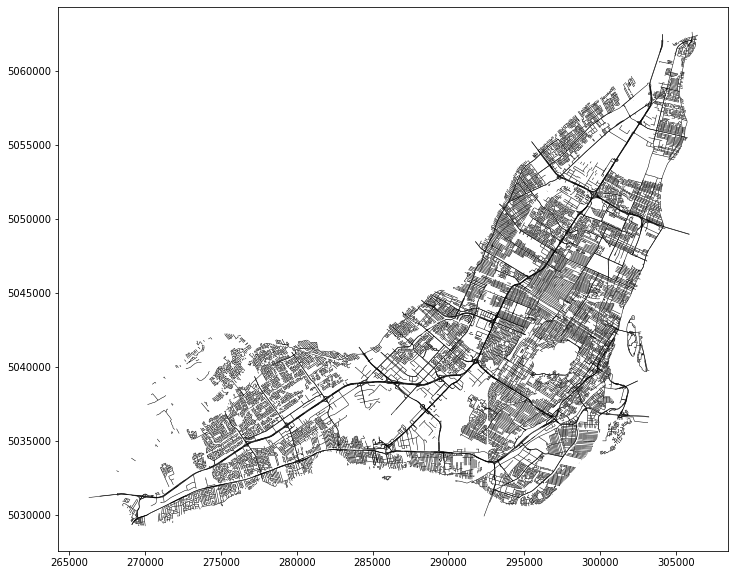

In [7]:
coords = dfF["coords"].values # Extracts the coords field as an array of lists

fig,ax = plt.subplots(figsize=(12,10))
line_segments = LineCollection(coords, linewidths=0.5, colors="black") # generates a collection of lines
ax.add_collection(line_segments) # adds the collection of lines to the axis

ax.autoscale(enable=True) # The axis doesn't automatically rescale when you plot the line collection - this forces that

**Much quicker**, wouldn't you agree?

**Issue:** The coordinates in this shapefile are for a specific "projection", or transformation. In this case the projection is epsg 32188 (found in the docs for the dataset). If we want to plot other data on top of this map, it is important that all the data is in a common projection. To deal with this, I've used the pyproj package to convert the coordinates to standard longitude and latitude values.

To use the package, first you need to inform it of the starting projection, and the desired projection

In [8]:
inProj = Proj(init='epsg:32188') # Projection of the current dataset
outProj = Proj(init='epsg:4326') # The projection that describes longitude and latitude

Applying the transformation then is straightforward enough

In [9]:
x = [coord[0] for coord in df["coords"][0]] # sample x coordinates
y = [coord[1] for coord in df["coords"][0]] # sample y coordinates
print(x,y)

xx,yy = transform(inProj,outProj,x,y)
print(xx,yy)

[285986.423, 285897.824] [5042145.34, 5042226.778]
[-73.74081689158373, -73.74195410403263] [45.51897292309056, 45.51970333219426]


But this is really slow when applied as a lambda function, or looped. The cell below should demonstrate that even 100 transformations is soul-crushingly slow.

In [10]:
rearrangeFunc = lambda points: [[point[0] for point in points], [point[1] for point in points]]
coords = df["coords"].apply(rearrangeFunc).values # Generate list of lists for road coordinates

coords_transformed = [transform(inProj,outProj,line[0],line[1]) for line in coords[:100]]
print(coords_transformed[:3])

[([-73.74081689158373, -73.74195410403263], [45.51897292309056, 45.51970333219426]), ([-73.70623530423326, -73.70629430924257, -73.7066906006261, -73.70671238591937, -73.70672742089161, -73.7067339221283, -73.70674081687979, -73.70674125317629, -73.70673739506636, -73.70673249273067, -73.7067187938898, -73.70670279139412, -73.70598918338322, -73.70594008055076, -73.70592368938514, -73.70588955127047, -73.70586238092206, -73.70582259798887, -73.70580455165172, -73.70576963807032, -73.70575540622157, -73.70572748455862, -73.70527461392628, -73.70521700121002], [45.52764649372649, 45.5275977886664, 45.52727777852048, 45.52725785085244, 45.527240095010775, 45.52722766433816, 45.52720731346731, 45.52718220468658, 45.52716673285825, 45.527154502790964, 45.527133469317114, 45.52711765952796, 45.52665575670994, 45.52662650755519, 45.52661987761785, 45.526611299794524, 45.52660895271501, 45.526609440802936, 45.52661226304422, 45.52662276497695, 45.52662918014678, 45.52664578905528, 45.526942499

I wagered that the iterative calling of the transform function might be the factor slowing this down and thus tried decided to reorganise the data to allow for a single call of the function.

In [11]:
xy = dfF["coords"].values # convert coords column of dataframe to list of lists

lengths = [len(line) for line in xy] # work out the length of each set of x,y pairs
x = np.array([points[0] for line in xy for points in line]) # make a single array with all the x values
y = np.array([points[1] for line in xy for points in line]) # make a single array with all the y values

inProj = Proj(init='epsg:32188') # reinitialise the starting coordinate projection
outProj = Proj(init='epsg:4326') # reinitialise the desired coordinate projection

xx,yy = transform(inProj,outProj,x,y) # transform the single lists of x and y values 
print(xx[:5],yy[:5])

[-73.74081689 -73.7419541  -73.7062353  -73.70629431 -73.7066906 ] [45.51897292 45.51970333 45.52764649 45.52759779 45.52727778]


Now we just need to split up the transformed coordinates to match the lengths of the original x,y pairs (so we preserve the correct number of x,y points in each line)

In [12]:
xy = list(zip(xx,yy)) # merge the transformed xx and yy coordinates
segments = np.split(xy,np.cumsum(lengths)) # split the list of transformed coordinates back into the original lengths of x,y pairs
print(segments[0])

[[-73.74081689  45.51897292]
 [-73.7419541   45.51970333]]


Now our "segments" variable can be used to initialise a line collection, to quickly plot all 40,000 lines in one go.

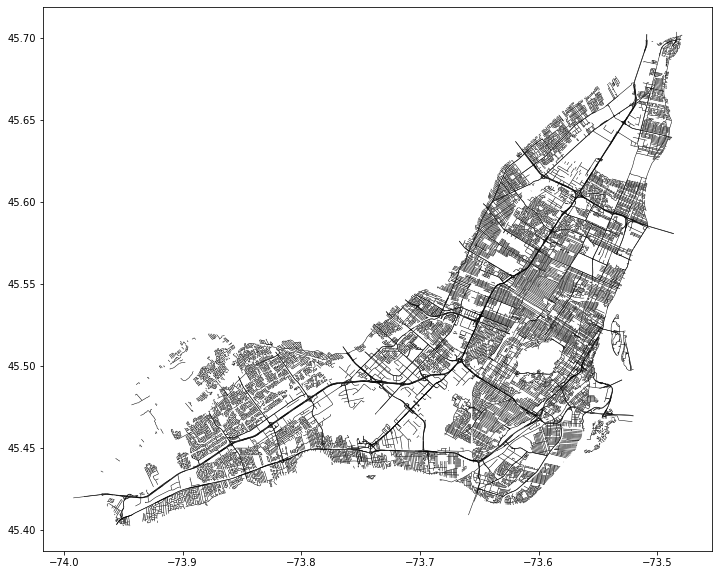

In [13]:
fig, ax = plt.subplots(figsize=(12,10))
line_segments = LineCollection(segments, linewidths=(0.5), colors="black",zorder=1)
ax.add_collection(line_segments) # adds the collection of lines to the axis

ax.autoscale(enable=True) # The axis doesn't automatically rescale when you plot the line collection - this forces that

Now we can start messing around with the figure aesthetics and getting this real pretty

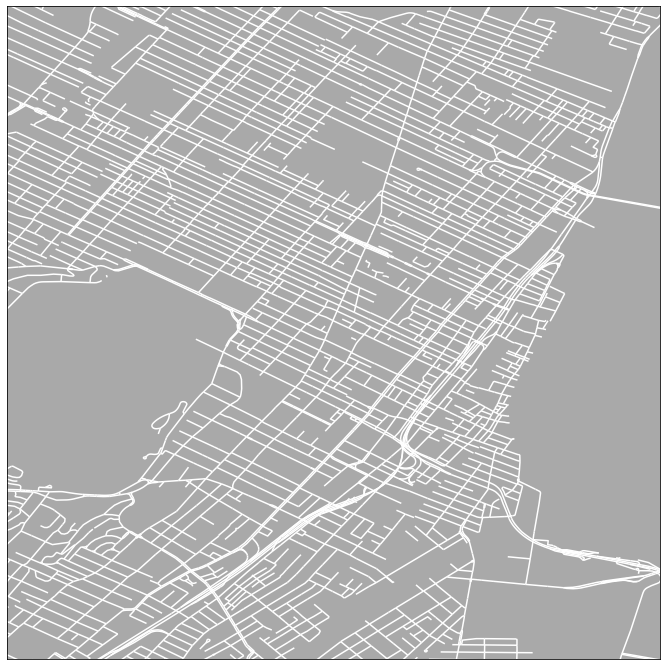

In [15]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_facecolor("darkgrey")
plt.tick_params(axis='both', which='both',length=0, labelbottom=False, labelleft=False)

line_segments = LineCollection(segments, linewidths=1.5, colors="white",zorder=1)
ax.add_collection(line_segments) # adds the collection of lines to the axis

ax.set_xlim(-73.60, -73.54)
ax.set_ylim(45.48, 45.54)
ax.set_aspect(aspect="equal")